This file was used to generate the North Carolina EQUAL Act fact sheet and the EQUAL Act Impact Comparison fact sheet

In [1]:
%run ../../../../../../recidiviz-research/utils/research_utils.py

In [2]:
adjust_plot_scale(0.4)

In [3]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [51]:
# States with senators that support the other bill
key_states = [
    "Iowa",
    "South Carolina",
    "Mississippi",
    "Utah",
    "Ohio",
    "Kentucky",
    "North Carolina",
    "Alaska",
    "Maine",
    "Wyoming",
    "West Virginia",
    "Kansas",
    "Missouri",
]

In [48]:
FED_DIRECTORY_PATH = "../state/FED/"
SENTENCING_DATA_PATH = FED_DIRECTORY_PATH + "sentencing_data/"

# Data dictionary:
# https://www.ussc.gov/sites/default/files/pdf/research-and-publications/datafiles/USSC_Public_Release_Codebook_FY99_FY20.pdf
common_columns = [
    # Total prison sentence months
    "TOTPRISN",
    # Month sentenced
    "SENTMON",
    # Year sentenced
    "SENTYR",
    # Primary drug type on the sentence
    "COMBDRG2",
    # Type of sentence imposed (prison, prison + fines, probation, probation + fines, just fines)
    "SENTIMP",
    # 1-5 Statutes on the sentences
    "NWSTAT1",
    "NWSTAT2",
    "NWSTAT3",
    "NWSTAT4",
    "NWSTAT5",
    # Sentencing district
    "DISTRICT",
    # Mandatory minimum
    "DRUGMIN",
    # The gram amount for the 1st drug type on the sentence
    "WGT1",
    # Race and ethnicity
    "NEWRACE",
]

new_data_columns = common_columns + [
    "OFFGUIDE",
]
old_data_columns = common_columns + [
    "OFFTYPSB",
]

# Supply some of the column types to silence warnings & process the large CSVs faster
column_dtypes = {
    "NWSTAT1": str,
    "NWSTAT2": str,
    "NWSTAT3": str,
    "NWSTAT4": str,
    "NWSTAT5": str,
}

new_data_files = [
    "opafy21nid.csv",
    "opafy20nid.csv",
    "opafy19nid.csv",
    "opafy18nid.csv",
]
# FY10-FY17 use the old offense type format
old_data_files = [f"opafy{year:02}nid.csv" for year in range(10, 18)]


def get_eligible_sentences(df: pd.DataFrame) -> pd.DataFrame:
    """Return only the sentences eligible for this policy:
    * non-life sentences ("TOTPRISN" != 9996)
    * with a crack/cocaine classification ("COMBDRG2" is in [1, 2])
    * sentenced to prison ("SENTIMP" is in [1, 2])
    """
    return df[
        (df["COMBDRG2"].isin([1, 2]))
        & (df["TOTPRISN"] != 9996)
        & (df["SENTIMP"].isin([1, 2]))
    ]


new_data = pd.DataFrame()
for file in new_data_files:
    temp = pd.read_csv(
        SENTENCING_DATA_PATH + file, usecols=new_data_columns, dtype=column_dtypes
    )
    temp = get_eligible_sentences(temp)
    new_data = pd.concat([new_data, temp])

old_data = pd.DataFrame()
for file in old_data_files:
    # Handle FY10 where the header row is lower case
    if "fy10" in file:
        diff_data_columns = [col.lower() for col in old_data_columns]
        diff_column_dtypes = {
            key.lower(): value for (key, value) in column_dtypes.items()
        }
        temp = pd.read_csv(
            SENTENCING_DATA_PATH + file,
            usecols=diff_data_columns,
            dtype=diff_column_dtypes,
        )
        temp.columns = [col.upper() for col in temp.columns]
    else:
        temp = pd.read_csv(
            SENTENCING_DATA_PATH + file, usecols=old_data_columns, dtype=column_dtypes
        )
    temp = get_eligible_sentences(temp)

    old_data = pd.concat([old_data, temp])

offguide_map = {
    1: "Administration of Justice",
    4: "Assault",
    8: "Commercialized Vice",
    9: "Drug Possession",
    10: "Drug Trafficking",
    12: "Extortion/Racketeering",
    13: "Firearms",
    17: "Immigration",
    19: "Kidnapping",
    21: "Money Laundering",
    22: "Murder",
    26: "Robbery",
    27: "Sexual Abuse",
    30: "Other",
}
new_data["primary_crime_type"] = new_data["OFFGUIDE"].map(offguide_map).fillna("Other")

offtype_map = {
    1: "Murder",
    4: "Sexual Abuse",
    10: "Drug Trafficking",
    11: "Drug Communication Facilities",
    12: "Drug Possession",
    13: "Firearms",
    18: "Fraud",
    23: "Money Laundering",
    24: "Extortion/Racketeering",
    26: "Civil Rights Offenses",
    27: "Immigration",
    29: "Prison Offenses",
    30: "Administration of Justice",
    35: "Traffic Violations and Other Offenses",
}
old_data["primary_crime_type"] = old_data["OFFTYPSB"].map(offtype_map).fillna("Other")

# Concatenate the two datasets together and rename columns
concat_data_columns = [
    "COMBDRG2",
    "TOTPRISN",
    "primary_crime_type",
    "SENTMON",
    "SENTYR",
    "NWSTAT1",
    "NWSTAT2",
    "NWSTAT3",
    "NWSTAT4",
    "NWSTAT5",
    "NEWRACE",
    "DISTRICT",
    "DRUGMIN",
    "WGT1",
]
sentence_data = pd.concat(
    [new_data[concat_data_columns], old_data[concat_data_columns]]
).reset_index(drop=True)
sentence_data = sentence_data.rename(
    {"TOTPRISN": "total_sentence_months", "SENTMON": "month", "SENTYR": "year"},
    axis=1,
)

sentence_data["drug_type"] = sentence_data["COMBDRG2"].apply(
    lambda x: "powder" if x == 1 else "crack"
)

# States of interest: NC, LA, ND, and OK
district_map = {
    0: "Maine",
    1: "Massachusetts",
    2: "New Hampshire",
    3: "Rhode Island",
    4: "Puerto Rico",
    5: "Connecticut",
    6: "New York",
    7: "New York",
    8: "New York",
    9: "New York",
    10: "Vermont",
    11: "Delaware",
    12: "New Jersey",
    13: "Pennsylvania",
    14: "Pennsylvania",
    15: "Pennsylvania",
    16: "Maryland",
    17: "North Carolina",
    18: "North Carolina",
    19: "North Carolina",
    20: "South Carolina",
    22: "Virginia",
    23: "Virginia",
    24: "West Virginia",
    25: "West Virginia",
    26: "Alabama",
    27: "Alabama",
    28: "Alabama",
    29: "Florida",
    30: "Florida",
    31: "Florida",
    32: "Georgia",
    33: "Georgia",
    34: "Georgia",
    35: "Louisiana",
    36: "Louisiana",
    37: "Mississippi",
    38: "Mississippi",
    39: "Texas",
    40: "Texas",
    41: "Texas",
    42: "Texas",
    43: "Kentucky",
    44: "Kentucky",
    45: "Michigan",
    46: "Michigan",
    47: "Ohio",
    48: "Ohio",
    49: "Tennessee",
    50: "Tennessee",
    51: "Tennessee",
    52: "Illinois",
    53: "Illinois",
    54: "Illinois",
    55: "Indiana",
    56: "Indiana",
    57: "Wisconsin",
    58: "Wisconsin",
    60: "Arkansas",
    61: "Arkansas",
    62: "Iowa",
    63: "Iowa",
    64: "Minnesota",
    65: "Missouri",
    66: "Missouri",
    67: "Nebraska",
    68: "North Dakota",
    69: "South Dakota",
    70: "Arizona",
    71: "California",
    72: "California",
    73: "California",
    74: "California",
    75: "Hawaii",
    76: "Idaho",
    77: "Montana",
    78: "Nevada",
    79: "Oregon",
    80: "Washington",
    81: "Washington",
    82: "Colorado",
    83: "Kansas",
    84: "New Mexico",
    85: "Oklahoma",
    86: "Oklahoma",
    87: "Oklahoma",
    88: "Utah",
    89: "Wyoming",
    90: "Dist of Columbia",
    91: "Virgin Islands",
    93: "Guam",
    94: "N Mariana Islands",
    95: "Alaska",
    96: "Louisiana",
}
sentence_data["sentencing_district"] = (
    sentence_data["DISTRICT"].map(district_map).fillna("Other")
)

race_ethnicity_type_map = {1: "White", 2: "Black", 3: "Hispanic", 6: "Other"}

sentence_data["race_or_ethnicity"] = (
    sentence_data["NEWRACE"].map(race_ethnicity_type_map).fillna("Unknown")
)

# Create a column `sentence_start_month` from the sentencing year & month data
sentence_data["day"] = 1
sentence_data["sentence_start_month"] = pd.to_datetime(
    sentence_data[["year", "month", "day"]]
).dt.date

sentence_data = sentence_data.drop(
    ["day", "month", "year", "DISTRICT", "NEWRACE", "COMBDRG2"], axis=1
)

# Drop 3 sentence types:
# 9992: <1 Day of Prison (# hrs)
# 9996: Life Imprisonment
# 9997: Prison ordered, no term specified
sentence_data = sentence_data[
    ~sentence_data["total_sentence_months"].isin([9992, 9996, 9997])
]

# Estimate the full-term release date for each sentence
sentence_data["estimated_release_date"] = (
    sentence_data["sentence_start_month"]
    + np.floor(sentence_data["total_sentence_months"]).apply(pd.offsets.MonthEnd)
).dt.date
print(len(sentence_data))
sentence_data.head()

,total_sentence_months,primary_crime_type,NWSTAT1,NWSTAT2,NWSTAT3,NWSTAT4,NWSTAT5,DRUGMIN,WGT1,drug_type,sentencing_district,race_or_ethnicity,sentence_start_month,estimated_release_date
0,151.0,Drug Trafficking,21841A1,21841B1C,NaN,NaN,NaN,0,111.9,powder,Florida,Black,2020-10-01,2033-04-30
1,84.0,Drug Trafficking,21846,21841,NaN,NaN,NaN,0,1000.0,powder,Maryland,Black,2020-10-01,2027-09-30
2,135.0,Drug Trafficking,21963,21960B1B,NaN,NaN,NaN,120,NaN,powder,Texas,Hispanic,2020-10-01,2031-12-31
3,108.0,Drug Trafficking,21841A1,21841B1A,21841B1C,NaN,NaN,60,19217.7,powder,South Carolina,Black,2020-10-01,2029-09-30
4,132.0,Drug Trafficking,21841A1,18924C,NaN,NaN,NaN,0,335.0,crack,Kentucky,Other,2020-10-01,2031-09-30


drug_type
crack     13127
powder    22597
Name: primary_crime_type, dtype: int64
drug_type            crack  powder
sentencing_district               
Alaska                  15      29
Iowa                   283     108
Kansas                  83      99
Kentucky               172     213
Maine                  123      39
Mississippi             78     203
Missouri               296     301
North Carolina        1330     925
Ohio                   305     553
South Carolina         734     533
Utah                    15      24
West Virginia          209      53
Wyoming                  3      11


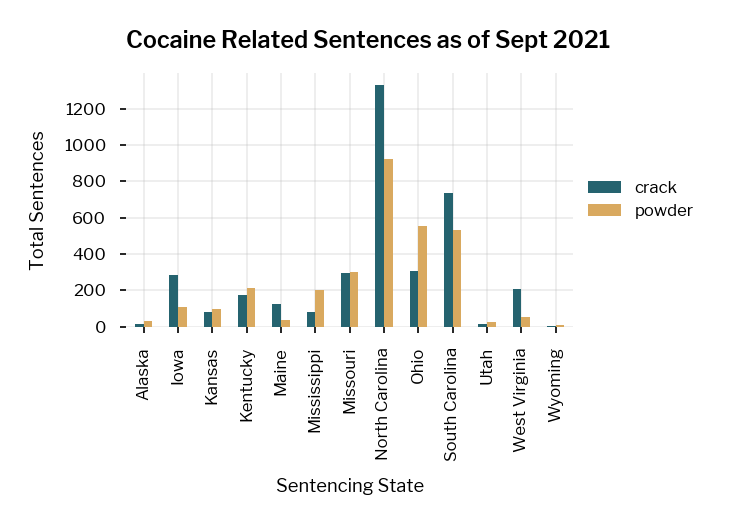

In [55]:
as_of_date = datetime.date(2021, 9, 1)

active_sentences = sentence_data[(sentence_data["estimated_release_date"] > as_of_date)]
print(active_sentences.groupby("drug_type").count()["primary_crime_type"])
active_sentences_per_state = (
    active_sentences[active_sentences["sentencing_district"].isin(key_states)]
    .groupby(["sentencing_district", "drug_type"])
    .count()
    .unstack("drug_type")["primary_crime_type"]
)
print(active_sentences_per_state)
active_sentences_per_state.plot.bar()
plt.xlabel("Sentencing State")
plt.ylabel("Total Sentences")
plt.title("Cocaine Related Sentences as of Sept 2021")
add_legend()

In [49]:
sum(sentence_data["estimated_release_date"] == sentence_data["sentence_start_month"])

0

In [ ]:
sentence_data["sentencing_district"].value_counts(dropna=False).plot.bar()

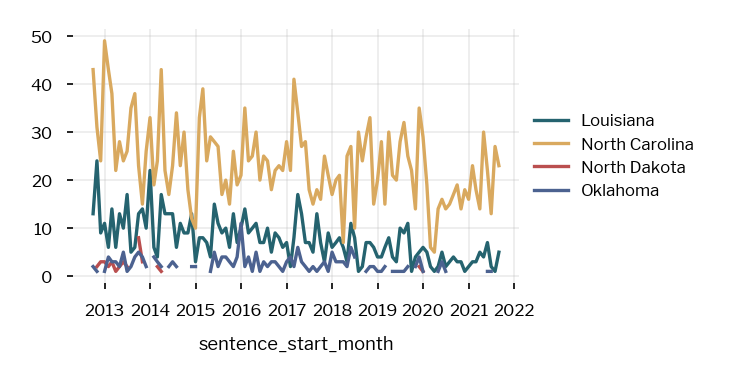

In [30]:
sentence_data[
    sentence_data["sentencing_district"].isin(
        ["Louisiana", "North Carolina", "North Dakota", "Oklahoma"]
    )
].groupby(["sentence_start_month", "sentencing_district"]).count()[
    "primary_crime_type"
].unstack(
    "sentencing_district"
).plot()
add_legend()

In [10]:
import os
import sys

sys.path.insert(0, os.path.relpath("../../../../.."))
from recidiviz.calculator.modeling.population_projection.predicted_admissions import (
    PredictedAdmissions,
)

In [11]:
historical_admissions = (
    sentence_data[sentence_data["sentencing_district"] != "Other"]
    .groupby(["sentence_start_month", "sentencing_district"])
    .count()["primary_crime_type"]
    .unstack("sentencing_district")
    .reset_index(drop=True)
    .transpose()
)
admissions_predictor = PredictedAdmissions(
    historical_data=historical_admissions, constant_admissions=False
)
admissions_predictor.get_time_step_estimate(96)
admissions_predictor.get_time_step_estimate(95 + 18)

/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimi

{'Alabama': 2.4317116972941255,
 'Alaska': 0,
 'Arizona': 0,
 'Arkansas': 2.2222222222222223,
 'California': 5.2727272727272725,
 'Colorado': 0.999998568105527,
 'Connecticut': 3.6,
 'Delaware': 1.6,
 'Dist of Columbia': 2.4444444444444446,
 'Florida': 6.181818181818182,
 'Georgia': 2.1666666666666665,
 'Hawaii': 0.9999738725516308,
 'Illinois': 4.090909090909091,
 'Indiana': 3.375,
 'Iowa': 1.4285714285714286,
 'Kansas': 0.7928904371610107,
 'Kentucky': 2.25,
 'Louisiana': 1.4285714285714286,
 'Maine': 2.5,
 'Maryland': 2.8333333333333335,
 'Massachusetts': 2.3333333333333335,
 'Michigan': 3.7777777777777777,
 'Minnesota': 1.0,
 'Mississippi': 1.6148028965405645,
 'Missouri': 2.5,
 'Nebraska': 0.9428483087010119,
 'Nevada': 0.99999597151056,
 'New Hampshire': 1.6387404459819146,
 'New Jersey': 2.5,
 'New Mexico': 0.9217702890211623,
 'New York': 14.25,
 'North Carolina': 9.666666666666666,
 'North Dakota': 0,
 'Ohio': 3.727272727272727,
 'Oklahoma': 0.9999787950399914,
 'Oregon': 1.55

In [12]:
admissions_predictor.gen_arima_output_df().unstack("outflow_to").sum()

             outflow_to      
predictions  Alabama               53.497657
             Alaska                        0
             Arizona                       0
             Arkansas              48.888889
             California                116.0
             Colorado              21.999968
             Connecticut                79.2
             Delaware                   35.2
             Dist of Columbia      53.777778
             Florida                   136.0
             Georgia               47.666667
             Hawaii                21.999425
             Illinois                   90.0
             Indiana                   74.25
             Iowa                  31.428571
             Kansas                 17.44359
             Kentucky                   49.5
             Louisiana             31.428571
             Maine                      55.0
             Maryland              62.333333
             Massachusetts         51.333333
             Michigan    

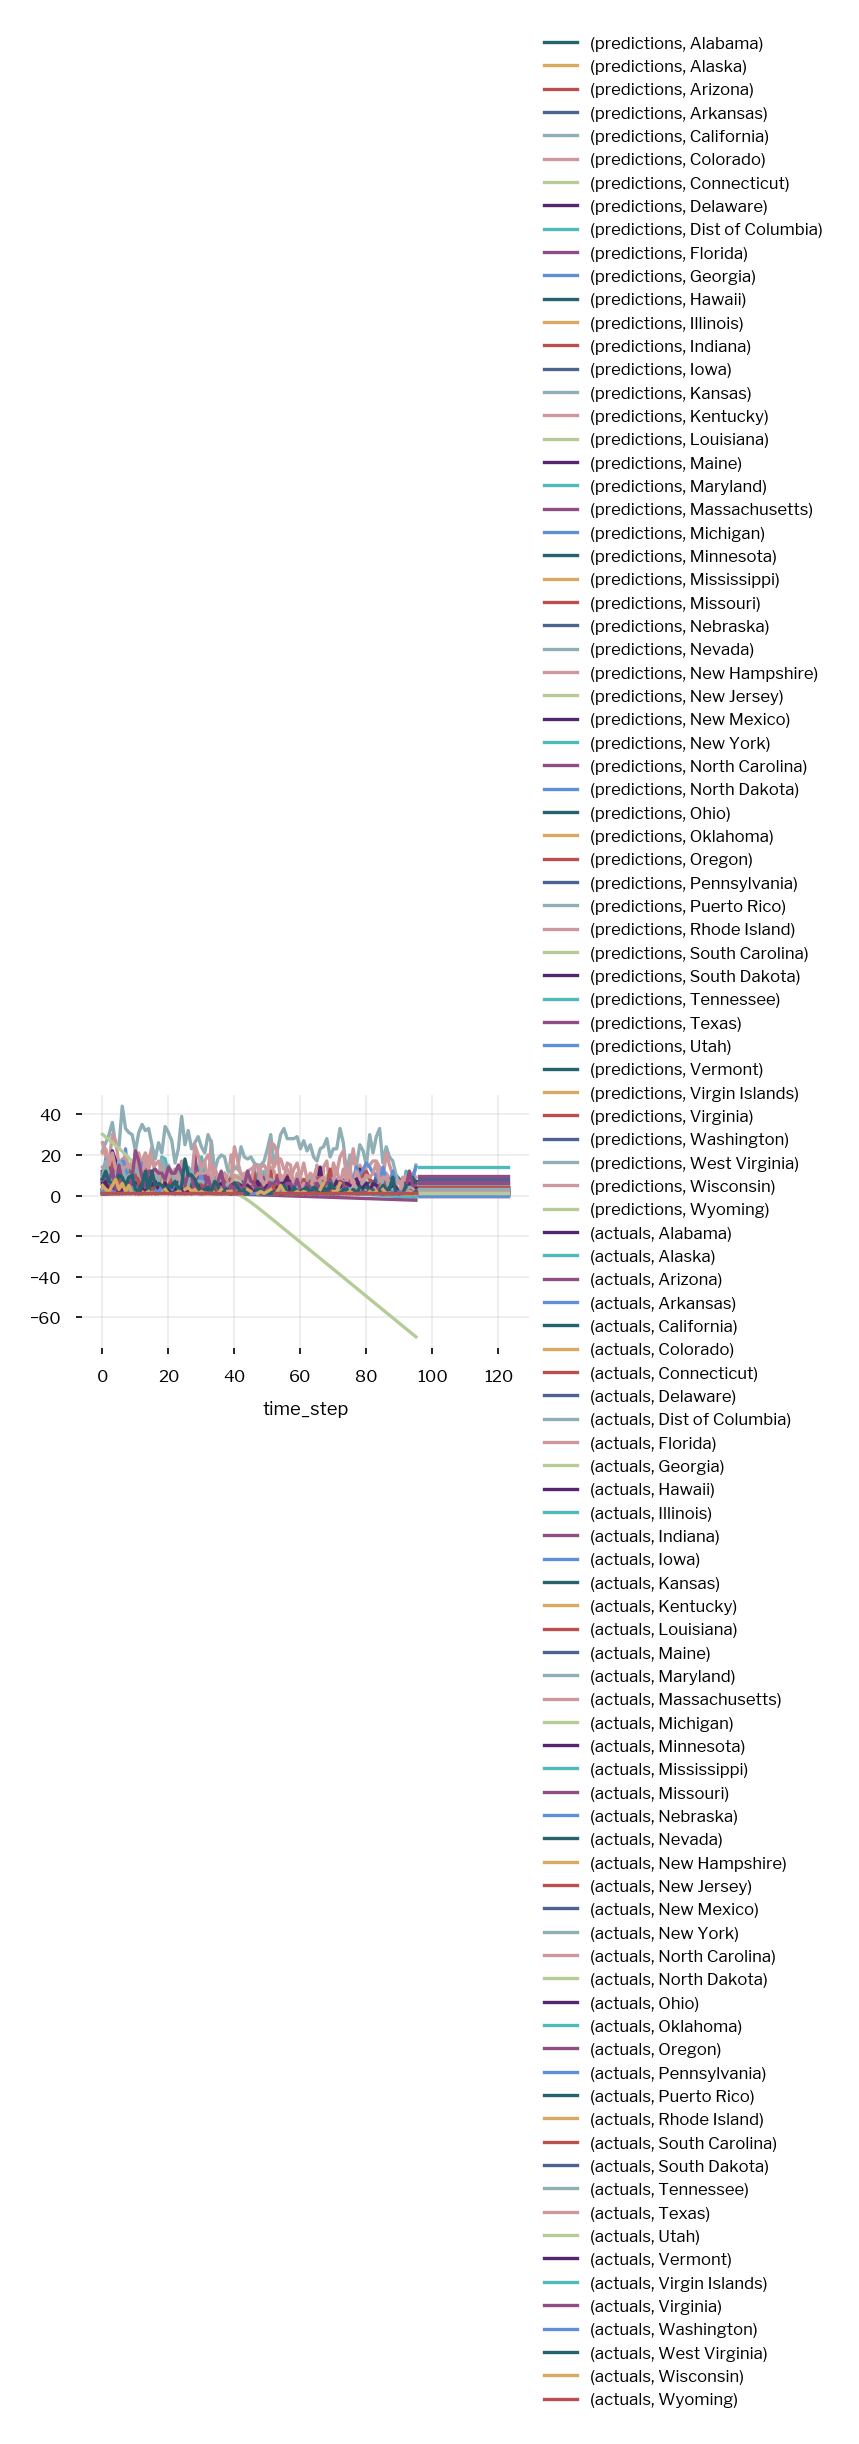

In [13]:
admissions_predictor.gen_arima_output_df().unstack("outflow_to").plot()
add_legend()

drug_type            crack  powder
sentencing_district               
Alabama               65.0   142.0
Alaska                 3.0     7.0
Arizona                NaN    63.0
Arkansas              64.0    82.0
California           110.0   513.0
Colorado              20.0    61.0
Connecticut           85.0    90.0
Delaware              16.0    14.0
Dist of Columbia      65.0    44.0
Florida              292.0  2414.0
Georgia              121.0   260.0
Guam                   NaN     1.0
Hawaii                 1.0     3.0
Illinois             164.0   265.0
Indiana               55.0   118.0
Iowa                  77.0    60.0
Kansas                 5.0    31.0
Kentucky              54.0    89.0
Louisiana             73.0   169.0
Maine                 71.0    17.0
Maryland             179.0   182.0
Massachusetts         75.0    75.0
Michigan             155.0   202.0
Minnesota             24.0    24.0
Mississippi           24.0    91.0
Missouri             107.0   128.0
Montana             

Text(0.0, 1.0, 'Active Crack Sentences Estimated as of April 2022')

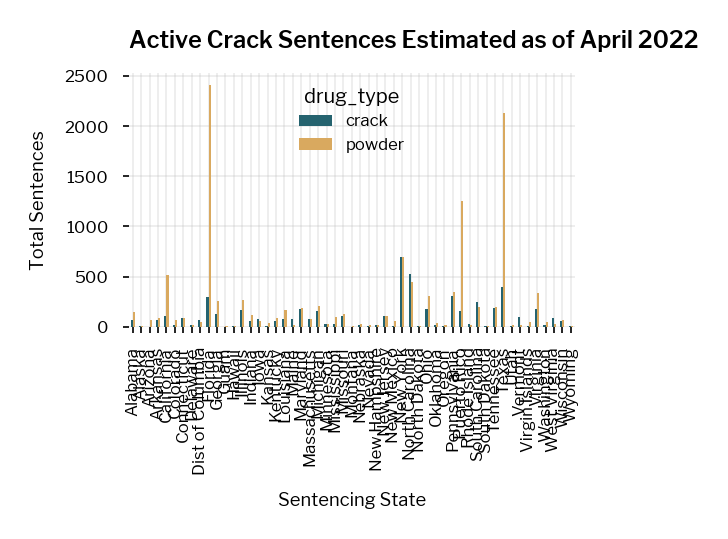

In [17]:
active_sentences_per_state = (
    sentence_data[
        (sentence_data["estimated_release_date"] > datetime.date(2022, 5, 1))
        & (sentence_data["sentencing_district"] != "Other")
    ]
    .groupby(["sentencing_district", "drug_type"])
    .count()
    .unstack("drug_type")["primary_crime_type"]
)
print(active_sentences_per_state)
active_sentences_per_state.plot.bar()
plt.xlabel("Sentencing State")
plt.ylabel("Total Sentences")
plt.title("Active Crack Sentences Estimated as of April 2022")

race_or_ethnicity    Black  Hispanic  Other  Unknown  White
sentencing_district                                        
Louisiana            174.0       NaN    NaN      1.0    2.0
North Carolina       722.0       9.0    9.0      3.0    8.0
North Dakota           6.0       NaN    NaN      NaN    1.0
Oklahoma              35.0       1.0    NaN      NaN    NaN


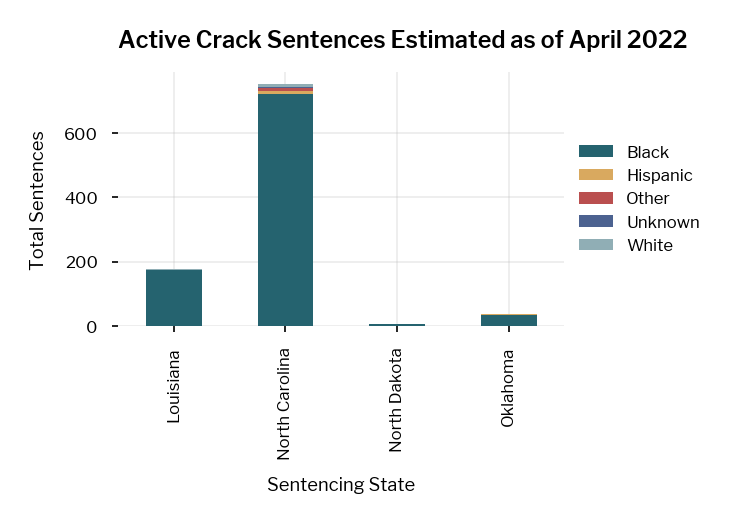

In [103]:
active_sentences_per_state = (
    sentence_data[
        (sentence_data["estimated_release_date"] > datetime.date(2022, 4, 1))
        & (sentence_data["sentencing_district"] != "Other")
    ]
    .groupby(["race_or_ethnicity", "sentencing_district"])
    .count()["primary_crime_type"]
    .unstack("race_or_ethnicity")
)
print(active_sentences_per_state)
active_sentences_per_state.plot.bar(stacked=True)
plt.xlabel("Sentencing State")
plt.ylabel("Total Sentences")
plt.title("Active Crack Sentences Estimated as of April 2022")
add_legend()

race_or_ethnicity
Black       789
Hispanic    140
Other        21
Unknown       1
White        39
Name: primary_crime_type, dtype: int64


Text(0, 0.5, '')

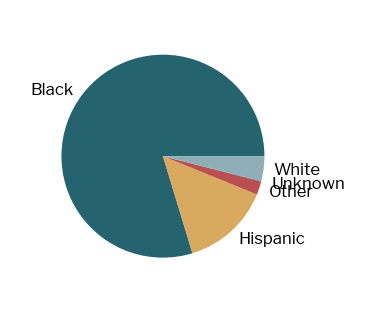

In [18]:
active_sentences_per_state = (
    sentence_data[
        (sentence_data["estimated_release_date"] > datetime.date(2022, 4, 1))
        & (sentence_data["sentencing_district"] != "Other")
        & (sentence_data["sentencing_district"] == "North Carolina")
    ]
    .groupby(["race_or_ethnicity"])
    .count()["primary_crime_type"]
)
print(active_sentences_per_state)
active_sentences_per_state.plot.pie()
# plt.title("Active Crack Sentences Estimated as of April 2022")
plt.ylabel("")

In [19]:
active_nc_sentences = sentence_data[
    (sentence_data["estimated_release_date"] > datetime.date(2022, 5, 1))
    & (sentence_data["sentencing_district"] == "North Carolina")
]
active_nc_sentences.head()

,total_sentence_months,primary_crime_type,NWSTAT1,NWSTAT2,NWSTAT3,NWSTAT4,NWSTAT5,DRUGMIN,WGT1,drug_type,sentencing_district,race_or_ethnicity,sentence_start_month,estimated_release_date
57,102,Drug Trafficking,21841A1,21841B1A,182,NaN,NaN,120,NaN,powder,North Carolina,Hispanic,2020-10-01,2029-03-31
112,38,Firearms,21841A1,21856A1,265861D,21841B1C,21841B1D,0,110.22,powder,North Carolina,White,2020-10-01,2023-11-30
115,120,Drug Trafficking,21846,21841A1,18924C1AI,21841B1B,21841B1C,60,NaN,crack,North Carolina,Black,2020-10-01,2030-09-30
144,45,Drug Trafficking,21841A1,18924C,21841B1C,18924C1A,NaN,0,0.49,crack,North Carolina,Black,2020-10-01,2024-06-30
154,168,Drug Trafficking,18924G1,21841A1,18924A2,NaN,NaN,0,10330.00,powder,North Carolina,Black,2020-10-01,2034-09-30


In [36]:
active_nc_sentences["DRUGMIN"].value_counts(dropna=False)

0       352
60      207
120     180
240       9
3         1
180       1
9996      1
Name: DRUGMIN, dtype: int64

In [91]:
active_nc_sentences[active_nc_sentences["DRUGMIN"] == 0][
    "primary_crime_type"
].value_counts(dropna=False)

Drug Trafficking          270
Firearms                   74
Extortion/Racketeering      5
Robbery                     2
Assault                     1
Name: primary_crime_type, dtype: int64

In [38]:
active_nc_sentences[active_nc_sentences["DRUGMIN"].isin([60, 120])]

,total_sentence_months,primary_crime_type,NWSTAT1,NWSTAT2,NWSTAT3,NWSTAT4,NWSTAT5,DRUGMIN,WGT1,sentencing_district,sentence_start_month,estimated_release_date
49,123,Drug Trafficking,21846,21841A1,18924C1AI,21841,21841B1C,60,39.93,North Carolina,2019-10-01,2029-12-31
73,39,Drug Trafficking,21846,21841A1,21841B1B,21841B1C,NaN,60,67.50,North Carolina,2019-10-01,2022-12-31
151,60,Drug Trafficking,21841A1,21841B1B,NaN,NaN,NaN,60,78.56,North Carolina,2019-10-01,2024-09-30
228,65,Drug Trafficking,21841A1,21841B1B,NaN,NaN,NaN,60,83.23,North Carolina,2019-11-01,2025-03-31
305,100,Drug Trafficking,21841A1,18924C,21841B1A,18924C1AI,NaN,120,307.20,North Carolina,2019-11-01,2028-02-29
...,...,...,...,...,...,...,...,...,...,...,...,...
15489,156,Drug Trafficking,21846,21841A1,21841B1B,NaN,NaN,60,224.32,North Carolina,2013-09-01,2026-08-31
15505,120,Drug Trafficking,21841A1,18922G1,21841B1B,21841B1C,18924A2,120,140.40,North Carolina,2013-09-01,2023-08-31
15544,130,Extortion/Racketeering,181962D,21846,21841B1B,NaN,NaN,60,28.00,North Carolina,2013-09-01,2024-06-30
15546,108,Drug Trafficking,181962D,21846,18922G,21841B1A,NaN,120,476.20,North Carolina,2013-09-01,2022-08-31


count      190.000000
mean       618.943905
std       1993.902792
min          4.000000
25%         57.137500
50%         99.895000
75%        254.862500
max      18993.000000
Name: WGT1, dtype: float64

count       137.000000
mean      13434.621595
std       57021.669995
min           6.600000
25%         303.200000
50%        1325.200000
75%        7400.000000
max      591498.000000
Name: WGT1, dtype: float64

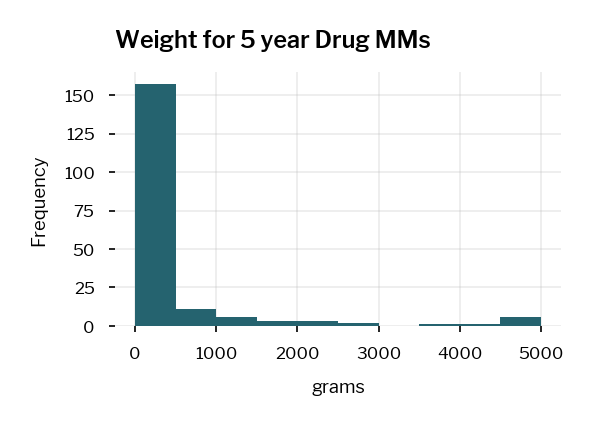

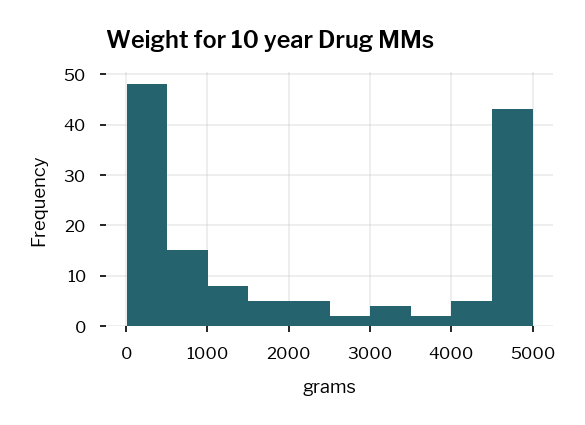

In [74]:
for mm in [60, 120]:
    plt.figure()
    group = active_nc_sentences[active_nc_sentences["DRUGMIN"] == mm]
    display(group["WGT1"].describe())
    np.clip(group["WGT1"], a_min=0, a_max=5000).plot.hist()
    plt.title(f"Weight for {mm/12:.0f} year Drug MMs")
    plt.xlabel("grams")

<AxesSubplot:ylabel='Frequency'>

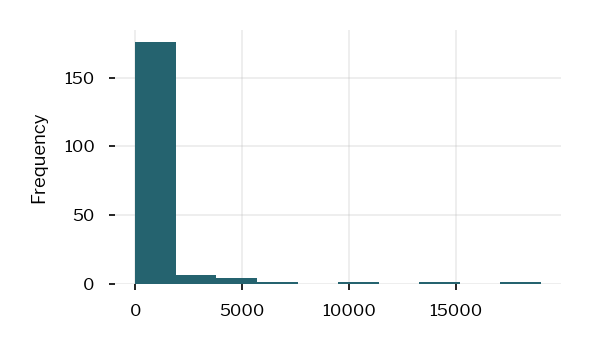

In [41]:
active_nc_sentences[active_nc_sentences["DRUGMIN"] == 60]["WGT1"].plot.hist()

In [82]:
active_nc_sentences["total_sentence_months"].describe()

count    751.000000
mean     134.194407
std       70.792181
min       24.000000
25%       84.000000
50%      120.000000
75%      165.000000
max      540.000000
Name: total_sentence_months, dtype: float64

In [94]:
print(
    f"Total impacted by 5 year MM: ",
    len(
        active_nc_sentences[  # (active_nc_sentences["DRUGMIN"] == 60) &
            (active_nc_sentences["WGT1"] > 28)
            & (active_nc_sentences["WGT1"] < 500)
            & (active_nc_sentences["total_sentence_months"] >= 60)
        ]
    ),
)
print(
    f"Total impacted by 10 year MM: ",
    len(
        active_nc_sentences[  # (active_nc_sentences["DRUGMIN"] == 120) &
            (active_nc_sentences["WGT1"] > 280)
            & (active_nc_sentences["WGT1"] < 5000)
            & (active_nc_sentences["total_sentence_months"] >= 120)
        ]
    ),
)

Total impacted by 5 year MM:  298
Total impacted by 10 year MM:  116


In [96]:
(298 + 116) / 751

0.5512649800266312

In [79]:
sum((mm_sentences["WGT1"] < 28) | (mm_sentences["WGT1"].isnull()))

5535

In [78]:
drug_type = "crack"
mm_sentences = active_sentences[active_sentences["drug_type"] == drug_type]
max_weight = mm_sentences["WGT1"].max()
ranges = [28, 160, 280, 500, 1600, 5000, max_weight]
print(len(mm_sentences))
sentences_per_weight_range = pd.DataFrame(
    index=pd.MultiIndex(levels=[[], []], codes=[[], []], names=["range", "state"])
)
for state_code in key_states:
    state_data = mm_sentences[mm_sentences["sentencing_district"] == state_code]
    sentences_per_weight_range.loc[(0, state_code), "total_sentences"] = sum(
        (state_data["WGT1"] < 28) | (state_data["WGT1"].isnull())
    )
    for index in range(len(ranges) - 1):
        sentences_per_weight_range.loc[
            (ranges[index], state_code), "total_sentences"
        ] = sum(
            # (mm_sentences["DRUGMIN"] == 60) &
            (state_data["WGT1"] >= ranges[index])
            & (state_data["WGT1"] < ranges[index + 1])
            #         & (mm_sentences["total_sentence_months"] >= 60)
        )
sentences_per_weight_range.unstack("range").sort_index()

13127


total_sentences                                        
range                     0      28    160   280    500    1600   5000
state                                                                 
Alaska                     5.0    4.0   1.0   1.0    2.0    2.0    0.0
Iowa                      85.0   51.0  18.0  24.0   39.0   33.0   33.0
Kansas                    25.0   17.0   5.0   5.0    6.0   16.0    9.0
Kentucky                  60.0   67.0  17.0  11.0    7.0    2.0    8.0
Maine                     31.0   34.0  10.0  18.0   13.0   12.0    5.0
Mississippi               16.0   27.0   9.0  14.0    8.0    0.0    4.0
Missouri                 120.0  112.0  19.0  14.0   20.0    9.0    2.0
North Carolina           421.0  379.0  95.0  71.0  133.0   93.0  138.0
Ohio                     147.0  109.0  20.0  19.0    7.0    1.0    2.0
South Carolina           159.0  160.0  46.0  69.0  137.0  101.0   62.0
Utah                       4.0    7.0   3.0   0.0    1.0    0.0    0.0
West Virginia            111.0   48.0  17.0  14.0   14.0    5.0    0.0
Wyoming                    1.0    1.0   0.0   0.0    1.0    0.0    0.0

In [81]:
drug_type = "powder"
mm_sentences = active_sentences[active_sentences["drug_type"] == drug_type]
max_weight = mm_sentences["WGT1"].max()
ranges = [28, 280, 400, 500, 4000, 5000, max_weight]
print(len(mm_sentences))
sentences_per_weight_range = pd.DataFrame(
    index=pd.MultiIndex(levels=[[], []], codes=[[], []], names=["range", "state"])
)
for state_code in key_states:
    state_data = mm_sentences[mm_sentences["sentencing_district"] == state_code]
    sentences_per_weight_range.loc[(0, state_code), "total_sentences"] = sum(
        (state_data["WGT1"] < ranges[0]) | (state_data["WGT1"].isnull())
    )
    for index in range(len(ranges) - 1):
        sentences_per_weight_range.loc[
            (ranges[index], state_code), "total_sentences"
        ] = sum(
            # (mm_sentences["DRUGMIN"] == 60) &
            (state_data["WGT1"] >= ranges[index])
            & (state_data["WGT1"] < ranges[index + 1])
            #         & (mm_sentences["total_sentence_months"] >= 60)
        )
sentences_per_weight_range.unstack("range").sort_index()

22597


total_sentences                                     
range                     0     28    280  400    500   4000   5000
state                                                              
Alaska                    11.0   2.0   1.0  0.0    7.0   2.0    6.0
Iowa                      31.0  14.0   4.0  1.0   21.0   1.0   36.0
Kansas                    24.0   1.0   0.0  0.0   14.0   2.0   58.0
Kentucky                  99.0  15.0   0.0  4.0   28.0   5.0   62.0
Maine                     13.0   1.0   0.0  1.0   12.0   2.0   10.0
Mississippi               55.0   8.0   2.0  2.0   25.0  10.0  101.0
Missouri                 149.0  10.0   5.0  2.0   49.0   4.0   82.0
North Carolina           311.0  64.0  12.0  3.0  125.0  20.0  390.0
Ohio                     223.0  37.0   6.0  6.0  118.0  10.0  153.0
South Carolina           114.0  34.0   4.0  3.0   82.0  19.0  277.0
Utah                       6.0   3.0   0.0  0.0    8.0   2.0    5.0
West Virginia             33.0   3.0   3.0  0.0   10.0   1.0    3.0
Wyoming                    5.0   1.0   0.0  0.0    3.0   0.0    2.0

In [86]:
drug_type = "powder"
mm_sentences = active_sentences[active_sentences["drug_type"] == drug_type]
max_weight = mm_sentences["WGT1"].max()
ranges = [28, 280, 400, 500, 4000, 5000, max_weight]
print(len(mm_sentences))
sentences_per_weight_range = pd.DataFrame()

sentences_per_weight_range.loc[0, "total_sentences"] = sum(
    (mm_sentences["WGT1"] < ranges[0]) | (mm_sentences["WGT1"].isnull())
)
for index in range(len(ranges) - 1):
    sentences_per_weight_range.loc[ranges[index], "total_sentences"] = sum(
        # (mm_sentences["DRUGMIN"] == 60) &
        (mm_sentences["WGT1"] >= ranges[index])
        & (mm_sentences["WGT1"] < ranges[index + 1])
        #         & (mm_sentences["total_sentence_months"] >= 60)
    )
sentences_per_weight_range.transpose()

22597


,0,28,280,400,500,4000,5000
total_sentences,8119.0,781.0,134.0,125.0,2562.0,439.0,10436.0


In [68]:
sentences_per_weight_range.sum()

total_sentences    7591.0
dtype: float64

Text(0.0, 1.0, 'Estimated Prison Population for Crack Cocaine\nWeight-Based Sentence Classification per Bill')

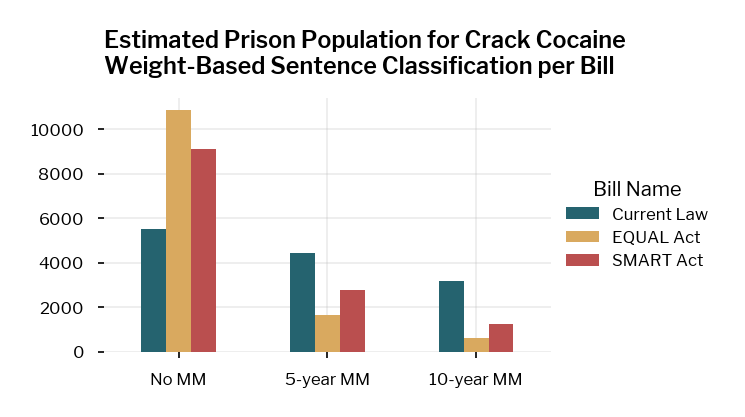

In [111]:
pd.DataFrame(
    {
        "Current Law": [5535, 4424, 3167],
        "EQUAL Act": [10869, 1666, 591],
        "SMART Act": [9130, 2776, 1220],
    },
    index=["No MM", "5-year MM", "10-year MM"],
).plot.bar()
add_legend(title="Bill Name")
plt.xticks(rotation=0)
plt.title(
    "Estimated Prison Population for Crack Cocaine\nWeight-Based Sentence Classification per Bill"
)

Text(0.0, 1.0, 'Estimated Prison Population for Powder Cocaine\nWeight-Based Sentence Classification per Bill')

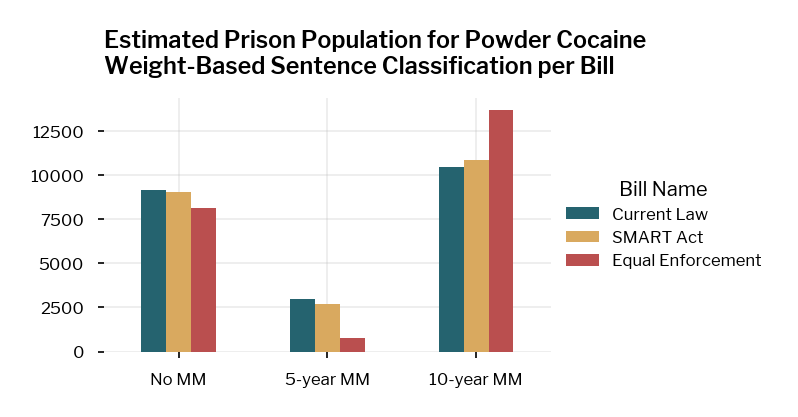

In [113]:
pd.DataFrame(
    {
        "Current Law": [9159, 3001, 10436],
        "SMART Act": [9034, 2687, 10875],
        "Equal Enforcement": [8119, 781, 13696],
    },
    index=["No MM", "5-year MM", "10-year MM"],
).plot.bar()
add_legend(title="Bill Name")
plt.xticks(rotation=0)
plt.title(
    "Estimated Prison Population for Powder Cocaine\nWeight-Based Sentence Classification per Bill"
)

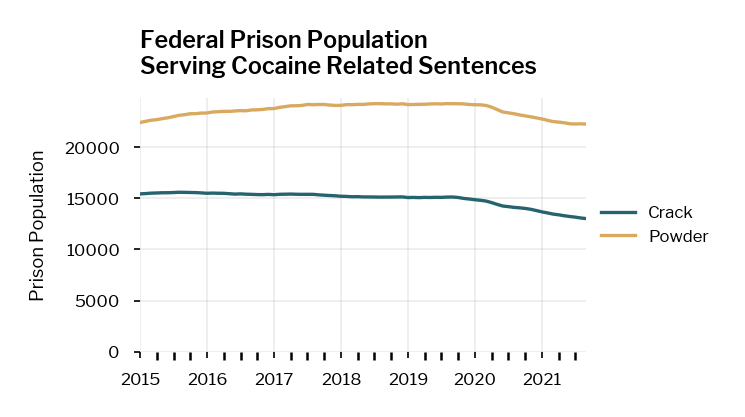

In [101]:
monthly_population = pd.DataFrame()
for report_date in pd.date_range(
    datetime.date(2015, 1, 1), datetime.date(2021, 9, 1), freq="MS"
):
    estimated_population = sentence_data[
        (sentence_data["sentence_start_month"] < report_date.date())
        & (report_date.date() < sentence_data["estimated_release_date"])
    ]
    monthly_population.loc[report_date, "Crack"] = sum(
        estimated_population["drug_type"] == "crack"
    )
    monthly_population.loc[report_date, "Powder"] = sum(
        estimated_population["drug_type"] == "powder"
    )
#     print(monthly_population.tail(1))
monthly_population.plot()
plt.ylim([0, None])
plt.ylabel("Prison Population")
plt.title(f"Federal Prison Population\nServing Cocaine Related Sentences")
#     plt.legend().remove()
add_legend()

/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


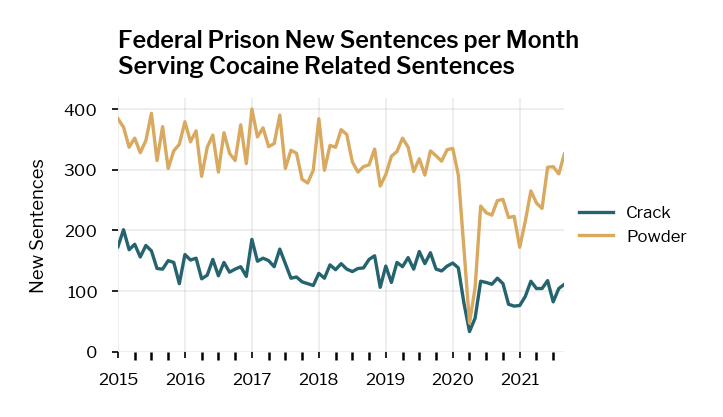

In [110]:
monthly_population = pd.DataFrame()
for report_date in pd.date_range(
    datetime.date(2015, 1, 1), datetime.date(2021, 9, 1), freq="MS"
):
    estimated_population = sentence_data[
        (sentence_data["sentence_start_month"] >= report_date.date())
        & (
            sentence_data["sentence_start_month"]
            < report_date.date() + pd.DateOffset(months=1)
        )
    ]
    monthly_population.loc[report_date, "Crack"] = sum(
        estimated_population["drug_type"] == "crack"
    )
    monthly_population.loc[report_date, "Powder"] = sum(
        estimated_population["drug_type"] == "powder"
    )
#     print(monthly_population.tail(1))
monthly_population.plot()
plt.ylim([0, None])
plt.ylabel("New Sentences")
plt.title(f"Federal Prison New Sentences per Month\nServing Cocaine Related Sentences")
#     plt.legend().remove()
add_legend()

In [154]:
sentence_data[sentence_data["sentence_start_month"].dt.year == report_year]

,total_sentence_months,primary_crime_type,NWSTAT1,NWSTAT2,NWSTAT3,NWSTAT4,NWSTAT5,DRUGMIN,WGT1,drug_type,sentencing_district,race_or_ethnicity,sentence_start_month,estimated_release_date,crime_type
871,57.0,Drug Trafficking,21846,21841A1,21841B1A,NaN,NaN,120,NaN,powder,California,Hispanic,2021-01-01,2025-09-30,powder_0
872,18.0,Drug Trafficking,21841A1,21841B1C,NaN,NaN,NaN,0,11.07,crack,Texas,Hispanic,2021-01-01,2022-06-30,crack_0
873,63.0,Drug Trafficking,4670503A,4670506A,21960B1BII,NaN,NaN,120,68000.00,powder,Florida,Hispanic,2021-01-01,2026-03-31,powder_5000
875,60.0,Drug Trafficking,21846,21841A1,21841B1C,21841B1A,NaN,120,8521.00,powder,Florida,Hispanic,2021-01-01,2025-12-31,powder_5000
876,24.0,Drug Trafficking,21846,NaN,NaN,NaN,NaN,60,2000.00,powder,Pennsylvania,Black,2021-01-01,2022-12-31,powder_500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4221,60.0,Drug Trafficking,4670506B,4670503A1,21960B1B,NaN,NaN,120,17925000.00,powder,Pennsylvania,Other,2021-01-01,2025-12-31,powder_5000
4222,60.0,Drug Trafficking,4670506B,4670503A1,21960B1B,NaN,NaN,120,17925000.00,powder,Pennsylvania,Other,2021-01-01,2025-12-31,powder_5000
4223,46.0,Drug Trafficking,21841A1,21841B1AII,NaN,NaN,NaN,120,13230.00,powder,Puerto Rico,Hispanic,2021-09-01,2025-06-30,powder_5000
4224,0.0,Drug Possession,21844,NaN,NaN,NaN,NaN,0,0.18,powder,Arizona,Unknown,2021-09-01,2021-09-30,powder_0


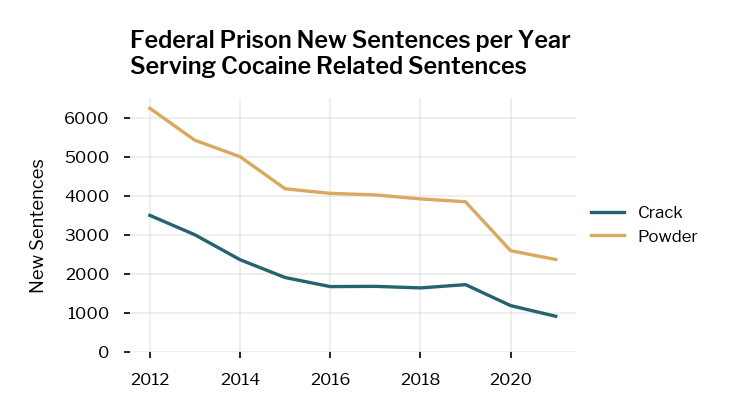

In [155]:
yearly_population = pd.DataFrame()
for report_year in range(2012, 2022):
    estimated_population = sentence_data[
        (sentence_data["sentence_start_month"].dt.year == report_year)
    ]
    yearly_population.loc[report_year, "Crack"] = sum(
        estimated_population["drug_type"] == "crack"
    )
    yearly_population.loc[report_year, "Powder"] = sum(
        estimated_population["drug_type"] == "powder"
    )
#     print(monthly_population.tail(1))
yearly_population.plot()
plt.ylim([0, None])
plt.ylabel("New Sentences")
plt.title(f"Federal Prison New Sentences per Year\nServing Cocaine Related Sentences")
#     plt.legend().remove()
add_legend()

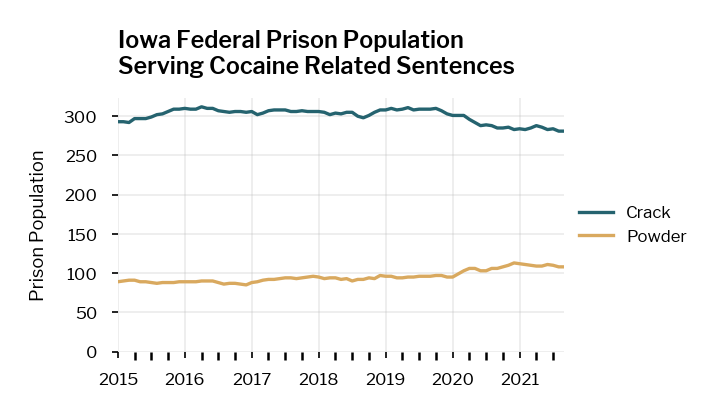

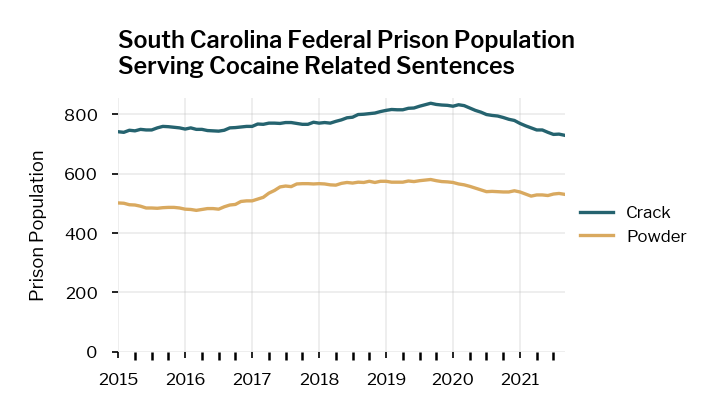

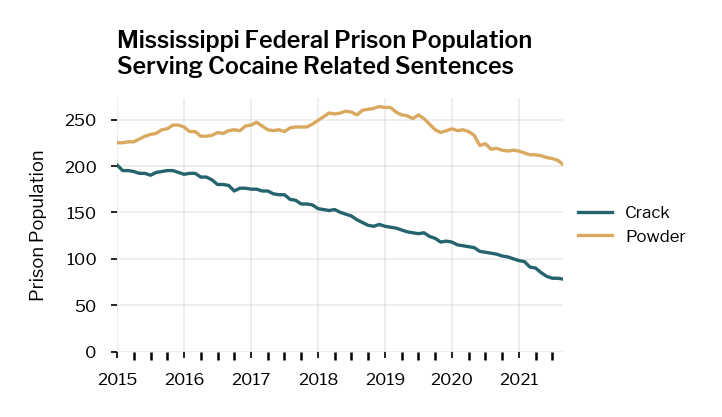

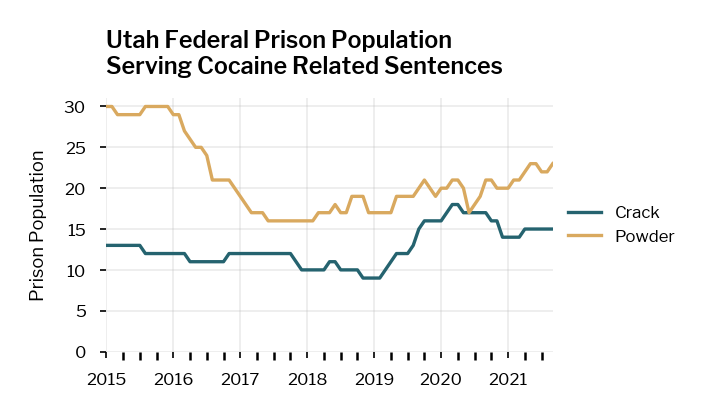

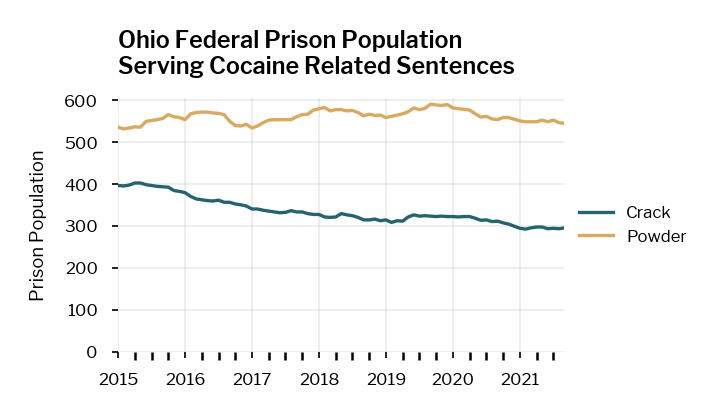

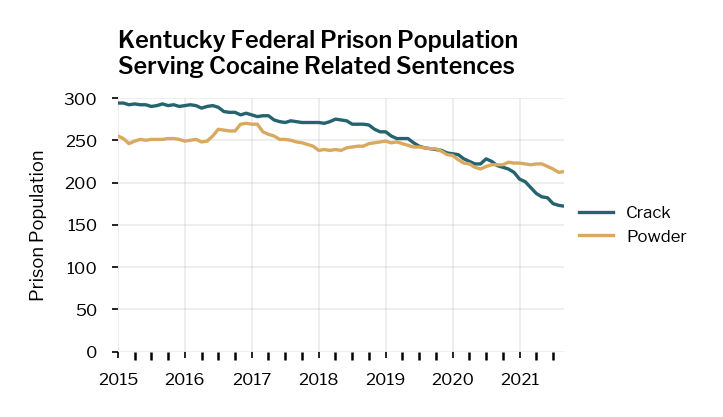

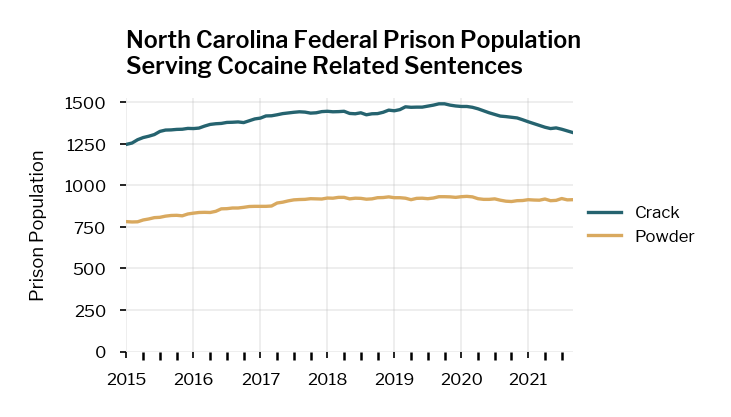

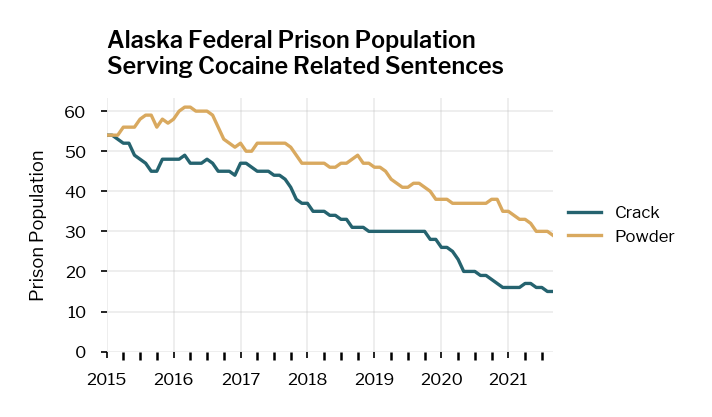

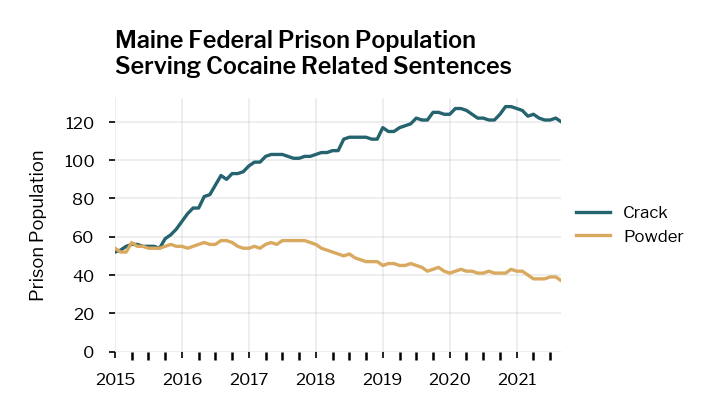

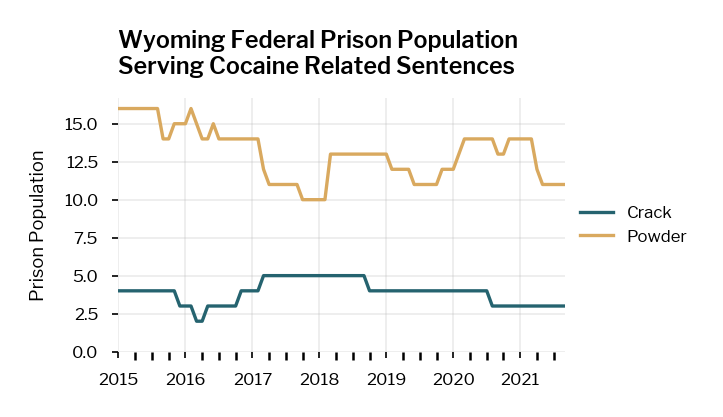

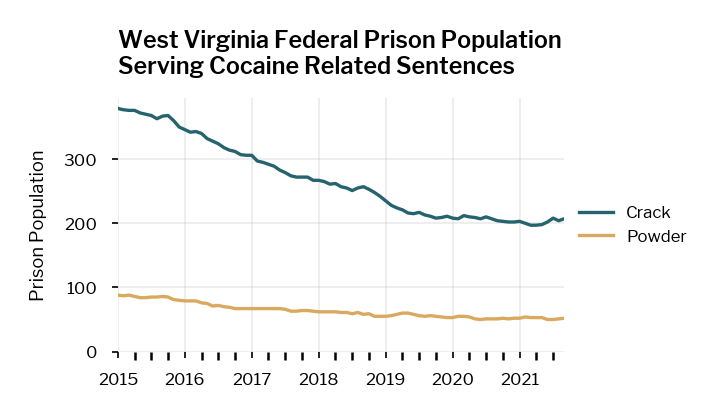

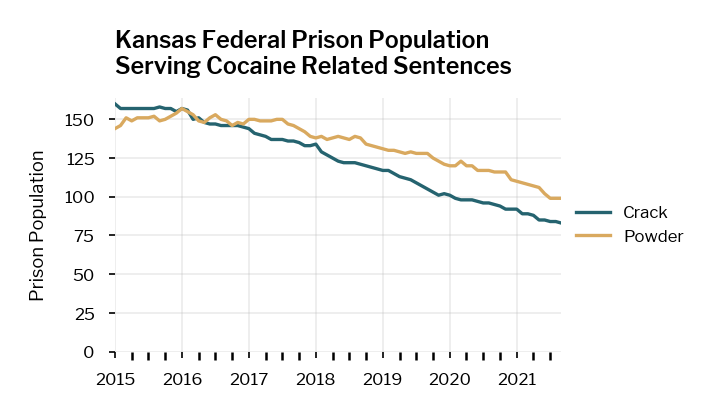

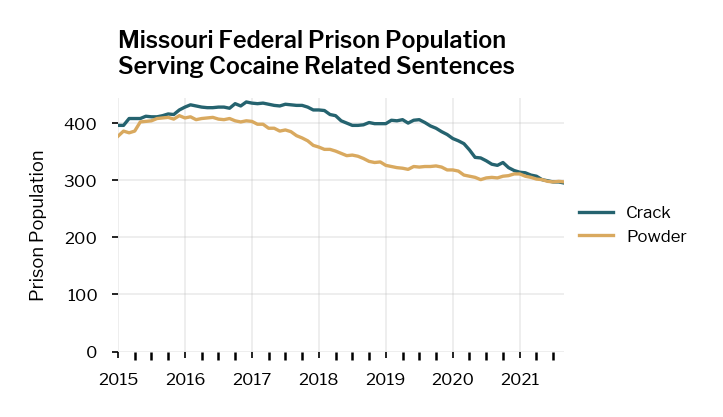

In [56]:
for state in key_states:
    monthly_population = pd.DataFrame()
    for report_date in pd.date_range(
        datetime.date(2015, 1, 1), datetime.date(2021, 9, 1), freq="MS"
    ):
        estimated_population = sentence_data[
            (sentence_data["sentence_start_month"] < report_date.date())
            & (report_date.date() < sentence_data["estimated_release_date"])
            & (sentence_data["sentencing_district"] == state)
        ]
        monthly_population.loc[report_date, "Crack"] = sum(
            estimated_population["drug_type"] == "crack"
        )
        monthly_population.loc[report_date, "Powder"] = sum(
            estimated_population["drug_type"] == "powder"
        )
    #     print(monthly_population.tail(1))
    monthly_population.plot()
    plt.ylim([0, None])
    plt.ylabel("Prison Population")
    plt.title(f"{state} Federal Prison Population\nServing Cocaine Related Sentences")
    #     plt.legend().remove()
    add_legend()

            total_population
2021-09-01             804.0
            total_population
2021-09-01             187.0
            total_population
2021-09-01              39.0
            total_population
2021-09-01               7.0


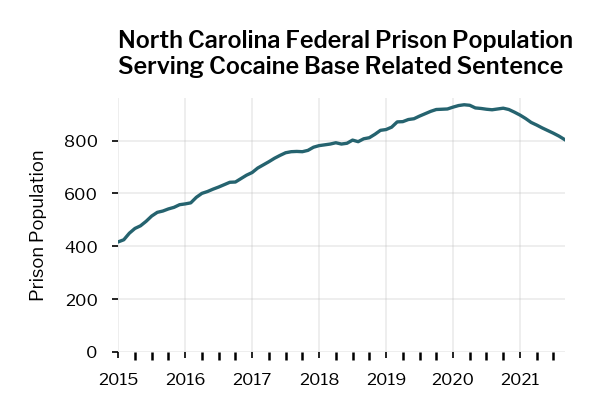

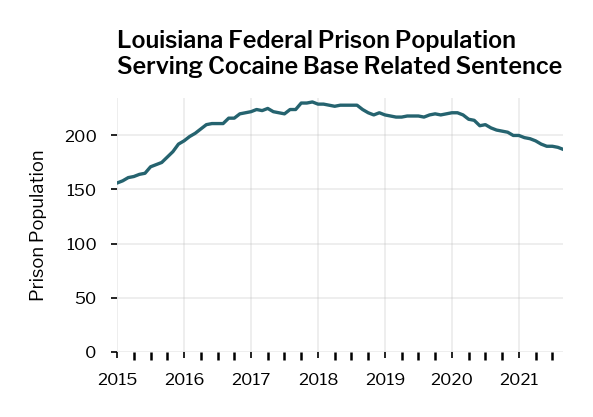

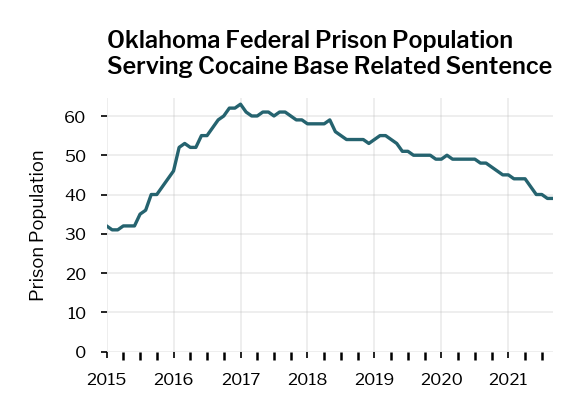

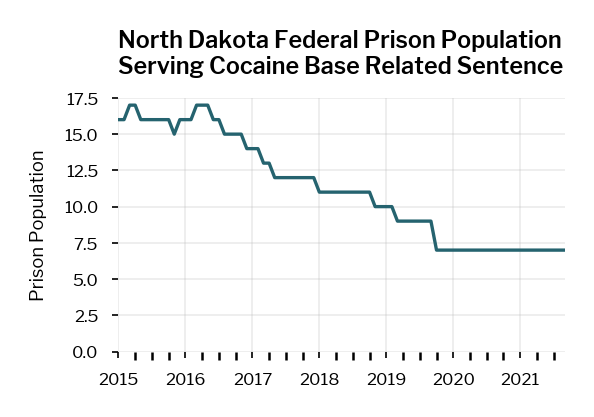

In [89]:
for state in ["North Carolina", "Louisiana", "Oklahoma", "North Dakota"]:
    monthly_population = pd.DataFrame()
    for report_date in pd.date_range(
        datetime.date(2015, 1, 1), datetime.date(2021, 9, 1), freq="MS"
    ):
        estimated_population = sentence_data[
            (sentence_data["sentence_start_month"] < report_date.date())
            & (report_date.date() < sentence_data["estimated_release_date"])
            & (sentence_data["sentencing_district"] == state)
        ]
        monthly_population.loc[report_date, "total_population"] = len(
            estimated_population
        )
    print(monthly_population.tail(1))
    monthly_population.plot()
    plt.ylim([0, None])
    plt.ylabel("Prison Population")
    plt.title(
        f"{state} Federal Prison Population\nServing Cocaine Base Related Sentence"
    )
    plt.legend().remove()